In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, f1_score, log_loss, classification_report, precision_recall_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, average_precision_score, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, RepeatedStratifiedKFold, cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import LabelEncoder

# Importing models
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Features variable
ageGroup = pd.read_csv('ageGroup.csv', sep=',')
ageGroup = ageGroup.drop('communication_onlinerate', axis=1)
ageGroup = ageGroup.drop('uid', axis=1)
ageGroup[ageGroup < 0] = 0
x = ageGroup.loc[:, ['task_id', 'adv_id', 'adv_prim_id', 'dev_id', 'slot_id', 'tags',
       'device_size', 'career', 'up_life_duration', 'indu_name', 'age', 'pt_d']]

# Target variable
y = ageGroup["label"]
y = LabelEncoder().fit_transform(y)



In [3]:
# Function for printing ROC and f1 score
def print_results(ytest, ypred, ypredproba):
    roc = roc_auc_score(ytest, ypredproba[:,1], average='weighted')
    f1 = f1_score(ytest, ypred, average='weighted')
    print('[ Metrics Evaluation ]\n')
    print('ROC Auc:    {}'.format(roc))
    print('f1 Score:     {}'.format(f1))
    print(('Classification Report:\n{}'.format(classification_report(ytest, ypred))))
    return roc, f1

In [4]:
# Train test split with stratifiedKfold, train: 80% test: 20%

cv = StratifiedKFold(n_splits=5, shuffle=True)
for train_idx, test_idx in cv.split(x, y):
    x_train, y_train = x.iloc[train_idx], y[train_idx]
    x_test, y_test = x.iloc[test_idx], y[test_idx]

# Oversample
over = SMOTE()

# Resample the train and test data with oversampling method
x_train_oversample, y_train_oversample = over.fit_resample(x_train, y_train)  
x_test_oversample, y_test_oversample = over.fit_resample(x_test, y_test)  

In [5]:
# LightGBM (oversample train & test data)

lgbm_params = {
    'max_depth': 16, 
    'num_leaves': 242, 
    'metrics' : 'auc', 
    'application':'binary', 
}

lgbm = LGBMClassifier()
lgbm.set_params(**lgbm_params)

lgbm.fit(x_train_oversample, y_train_oversample)

y_pred_oversample = lgbm.predict(x_test_oversample)
y_predproba_oversample = lgbm.predict_proba(x_test_oversample)      

roc_lgbm_oversample_1, f1_lgbm_oversample_1 = print_results(y_test_oversample, y_pred_oversample, y_predproba_oversample)  
print(confusion_matrix(y_test_oversample, y_pred_oversample).ravel())

[ Metrics Evaluation ]

ROC Auc:    0.951555724732718
f1 Score:     0.8810183233552006
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.88     67228
           1       0.89      0.87      0.88     67228

    accuracy                           0.88    134456
   macro avg       0.88      0.88      0.88    134456
weighted avg       0.88      0.88      0.88    134456

[59705  7523  8474 58754]


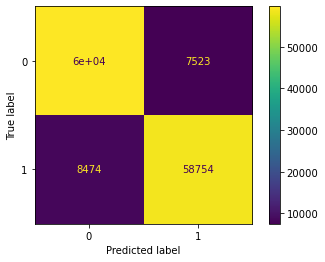

In [6]:
cm = confusion_matrix(y_test_oversample, y_pred_oversample, labels=lgbm.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgbm.classes_)
cm_display.plot()

In [7]:
# LightGBM Classifier (oversample train data)

lgbm_params = {
      'max_depth': 16, 
    'num_leaves': 242, 
    'metrics' : 'auc', 
    'application':'binary', 
}

lgbm = LGBMClassifier()
lgbm.set_params(**lgbm_params)

lgbm.fit(x_train_oversample, y_train_oversample)


y_pred = lgbm.predict(x_test)
y_predproba = lgbm.predict_proba(x_test)      

roc_lgbm_1, f1_lgbm_1 = print_results(y_test,y_pred, y_predproba) 
print(confusion_matrix(y_test, y_pred).ravel())

[ Metrics Evaluation ]

ROC Auc:    0.6623086452975041
f1 Score:     0.8954227691907503
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.89      0.93     67228
           1       0.10      0.29      0.14      2772

    accuracy                           0.86     70000
   macro avg       0.53      0.59      0.54     70000
weighted avg       0.93      0.86      0.90     70000

[59705  7523  1968   804]


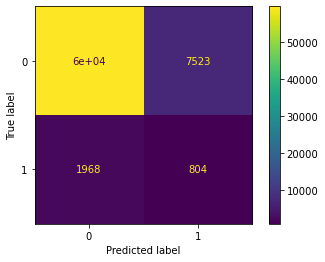

In [8]:
cm = confusion_matrix(y_test, y_pred, labels=lgbm.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgbm.classes_)
cm_display.plot()

In [9]:
# xgboost classifier (oversample train & test set)

xgb_params =  {
    'use_label_encoder': False,
    'eval_metric': 'mlogloss'
}

xgbc = XGBClassifier()
xgbc.set_params(**xgb_params)

xgbc.fit(x_train_oversample, y_train_oversample)

y_pred_oversample = xgbc.predict(x_test_oversample)
y_predproba_oversample = xgbc.predict_proba(x_test_oversample)      

roc_xgb_oversample_1, f1_xgb_oversample_1 = print_results(y_test_oversample, y_pred_oversample, y_predproba_oversample)  
print(confusion_matrix(y_test_oversample, y_pred_oversample).ravel())

[ Metrics Evaluation ]

ROC Auc:    0.9516645589362769
f1 Score:     0.8809139304851015
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88     67228
           1       0.87      0.89      0.88     67228

    accuracy                           0.88    134456
   macro avg       0.88      0.88      0.88    134456
weighted avg       0.88      0.88      0.88    134456

[58503  8725  7285 59943]


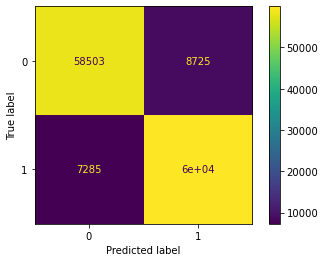

In [10]:
cm = confusion_matrix(y_test_oversample, y_pred_oversample, labels=xgbc.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgbc.classes_)
cm_display.plot()

In [11]:
# xgboost classifier

xgb_params =  {
    'use_label_encoder': False,
    'eval_metric': 'mlogloss'
}

xgbc = XGBClassifier()
xgbc.set_params(**xgb_params)

xgbc.fit(x_train_oversample, y_train_oversample)

y_pred = xgbc.predict(x_test)
y_predproba = xgbc.predict_proba(x_test)      

roc_xgb_1, f1_xgb_1 = print_results(y_test,y_pred, y_predproba)
print(confusion_matrix(y_test, y_pred).ravel())

[ Metrics Evaluation ]

ROC Auc:    0.6640314015942475
f1 Score:     0.8867249850659107
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.87      0.92     67228
           1       0.10      0.33      0.15      2772

    accuracy                           0.85     70000
   macro avg       0.53      0.60      0.53     70000
weighted avg       0.93      0.85      0.89     70000

[58503  8725  1846   926]


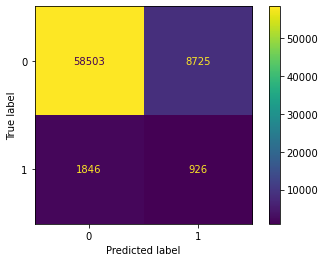

In [12]:
cm = confusion_matrix(y_test, y_pred, labels=xgbc.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgbc.classes_)
cm_display.plot()

In [13]:
# Decision Tree Classifier (oversample train & test set)

dtc_params =  {
    'min_samples_split': 19,
    'criterion': 'entropy',
    'min_samples_leaf': 2,
    'max_depth': 48,
}

dtc =  DecisionTreeClassifier()
dtc.set_params(**dtc_params)

dtc.fit(x_train_oversample, y_train_oversample)

y_pred_oversample = dtc.predict(x_test_oversample)
y_predproba_oversample = dtc.predict_proba(x_test_oversample)         

roc_dtc_oversample_1, f1_dtc_oversample_1 = print_results(y_test_oversample, y_pred_oversample, y_predproba_oversample)  
print(confusion_matrix(y_test_oversample, y_pred_oversample).ravel())

[ Metrics Evaluation ]

ROC Auc:    0.8180367019076422
f1 Score:     0.7626060213128433
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.87      0.79     67228
           1       0.84      0.66      0.74     67228

    accuracy                           0.77    134456
   macro avg       0.78      0.77      0.76    134456
weighted avg       0.78      0.77      0.76    134456

[58452  8776 22796 44432]


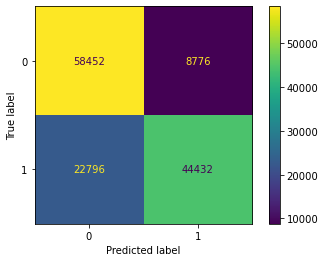

In [14]:
cm = confusion_matrix(y_test_oversample, y_pred_oversample, labels=dtc.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dtc.classes_)
cm_display.plot()

In [15]:
# Decision Tree Classifier (oversample train set)

dtc_params =  {
    'min_samples_split': 19,
    'criterion': 'entropy',
    'min_samples_leaf': 2,
    'max_depth': 48,
}

dtc =  DecisionTreeClassifier()
dtc.set_params(**dtc_params)

dtc.fit(x_train_oversample, y_train_oversample)
y_pred = dtc.predict(x_test)
y_predproba = dtc.predict_proba(x_test)      

roc_dtc_1, f1_dtc_1 = print_results(y_test, y_pred, y_predproba)  
print(confusion_matrix(y_test, y_pred).ravel()) 

[ Metrics Evaluation ]

ROC Auc:    0.5817333474224946
f1 Score:     0.8825335766184028
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.87      0.91     67228
           1       0.07      0.23      0.11      2772

    accuracy                           0.84     70000
   macro avg       0.52      0.55      0.51     70000
weighted avg       0.93      0.84      0.88     70000

[58428  8800  2121   651]


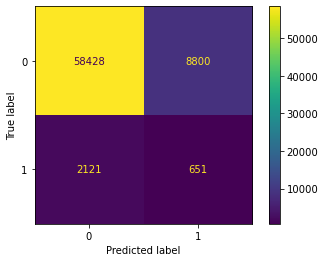

In [16]:
cm = confusion_matrix(y_test, y_pred, labels=dtc.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dtc.classes_)
cm_display.plot()

In [17]:
# Random Forest Classifier (oversample train & test set)

rfc_params =  {
    'min_samples_split': 2,
    'max_leaf_nodes':-22,
    'max_depth': 41
}

rfc = RandomForestClassifier()
rfc.set_params(**rfc_params)

rfc.fit(x_train_oversample, y_train_oversample)

y_pred_oversample = rfc.predict(x_test_oversample)
y_predproba_oversample = rfc.predict_proba(x_test_oversample)      

roc_rfc_oversample_1, f1_rfc_oversample_1 = print_results(y_test_oversample, y_pred_oversample, y_predproba_oversample)  
print(confusion_matrix(y_test_oversample, y_pred_oversample).ravel())

[ Metrics Evaluation ]

ROC Auc:    0.8877399491645372
f1 Score:     0.7884745202169396
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.92      0.82     67228
           1       0.90      0.66      0.76     67228

    accuracy                           0.79    134456
   macro avg       0.81      0.79      0.79    134456
weighted avg       0.81      0.79      0.79    134456

[62047  5181 22773 44455]


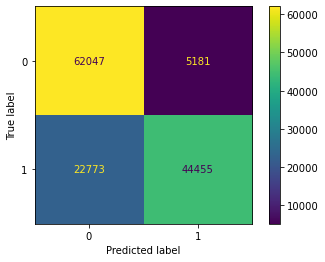

In [18]:
cm = confusion_matrix(y_test_oversample, y_pred_oversample, labels=rfc.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc.classes_)
cm_display.plot()

In [19]:
# Random Forest Classifier (oversample train set)

rfc_params =  {
    'min_samples_split': 2,
    'max_leaf_nodes':-22,
    'max_depth': 41
}

rfc = RandomForestClassifier()
rfc.set_params(**rfc_params)

rfc.fit(x_train_oversample, y_train_oversample)

y_pred = rfc.predict(x_test)
y_predproba = rfc.predict_proba(x_test)      

roc_rfc_1, f1_rfc_1 = print_results(y_test, y_pred, y_predproba)  
print(confusion_matrix(y_test, y_pred).ravel()) 

[ Metrics Evaluation ]

ROC Auc:    0.606970541804242
f1 Score:     0.9105831125080978
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94     67228
           1       0.09      0.19      0.12      2772

    accuracy                           0.89     70000
   macro avg       0.53      0.55      0.53     70000
weighted avg       0.93      0.89      0.91     70000

[62006  5222  2256   516]


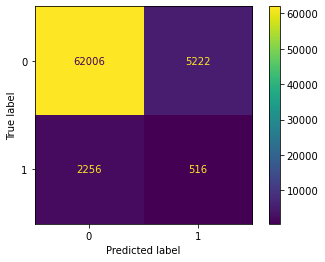

In [20]:
cm = confusion_matrix(y_test, y_pred, labels=rfc.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc.classes_)
cm_display.plot()

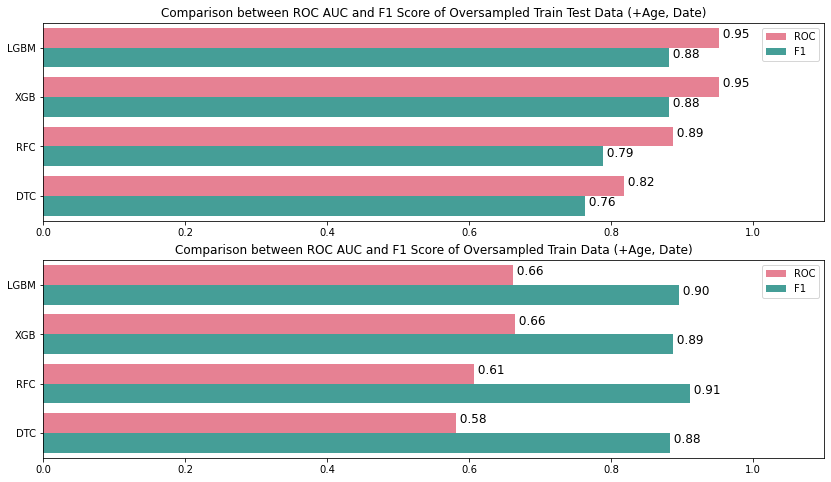

<Figure size 720x360 with 0 Axes>

In [21]:
# Plot the comparison between ROC AUC and F1 Score for Oversampled Train Test Data

fig, axs = plt.subplots(nrows=2, figsize=(14,8))

labelArr = np.array(['ROC', 'ROC', 'ROC', 'ROC', 'F1', 'F1', 'F1', 'F1'])
metricsArr = np.array([roc_lgbm_oversample_1, roc_xgb_oversample_1, roc_rfc_oversample_1, roc_dtc_oversample_1, f1_lgbm_oversample_1, f1_xgb_oversample_1, f1_rfc_oversample_1, f1_dtc_oversample_1])
xArr = np.array(['LGBM', 'XGB', 'RFC', 'DTC', 'LGBM', 'XGB', 'RFC', 'DTC'])

metricsArr2 = np.array([roc_lgbm_1, roc_xgb_1, roc_rfc_1, roc_dtc_1, f1_lgbm_1, f1_xgb_1, f1_rfc_1, f1_dtc_1])

# Plot ROC and F1 from all models
plt.figure(figsize=(10, 5))
bar = sns.barplot(metricsArr, xArr, hue=labelArr, palette='husl', ax=axs[0])
bar2 = sns.barplot(metricsArr2, xArr, hue=labelArr, palette='husl', ax=axs[1])
axs[0].set(xlim = (None, 1.1))
axs[1].set(xlim = (None, 1.1))
axs[0].set_title('Comparison between ROC AUC and F1 Score of Oversampled Train Test Data (+Age, Date)')
axs[1].set_title('Comparison between ROC AUC and F1 Score of Oversampled Train Data (+Age, Date)')
# Put the exact value in the graph
for p in bar.patches: 
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    bar.text(x+width, 
           y+height/2, 
           " %.2f"%width, 
           horizontalalignment="left",fontsize=12)
    
for p in bar2.patches: 
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    bar2.text(x+width, 
           y+height/2, 
           " %.2f"%width, 
           horizontalalignment="left",fontsize=12)